In [1]:
from __future__ import division
from sklearn.model_selection import train_test_split

from random_forest import RandomForest
from gui import Gui
import config
import helpers
import numpy as np

from reducer import Reducer

In [2]:
red_ruleset = []
new_ruleset = []

feature_names = config.feature_names

## Setting variables

In [3]:
groundTruth = helpers.create_separate_files_status("data.csv")

In [4]:
x_train, x_test, y_train, y_test = train_test_split(helpers.create_dataframe("dataWoName.csv"), groundTruth, test_size=0.33,
                                                        random_state=42)

In [5]:
rf = RandomForest(x_test, y_test, x_train, y_train)

In [6]:
rules_rf = rf.get_all_rules(forest=rf.rf)

In [7]:
reducer = Reducer(rules_rf, rf)

In [8]:
red_ruleset = reducer.reduce_rules()


In [9]:
len(red_ruleset)

358

In [11]:
len(rules_rf)

358

In [12]:
percentage = np.arange(1, 100, 1)

In [13]:
numtoelim = [int((1 - (int(x) / 100)) * len(red_ruleset)) for x in percentage]

In [14]:
len(numtoelim)

99

In [15]:
import itertools

items = np.arange(1, 23, 1)
powerset = [x for length in range(len(items)+1) for x in itertools.combinations(items, length)]

In [16]:
len(powerset)

4194304

In [112]:
new_ruleset_1_2_3 = [reducer.eliminate_weakest_rules_2(favourite_features=[], k=4, numtoelim=x, ruleset=red_ruleset, xtrain=x_train, ytrain=y_train) for x in numtoelim]

In [113]:
number_rules = [len(new_ruleset_1_2_3[i]) for i in range(0, len(new_ruleset_1_2_3))]

In [114]:
vector_pred_1_2_3 = [rf.apply_ruleset_get_vector_new(ruleset=x, xtest=x_test) for x in new_ruleset_1_2_3]

In [115]:
acc = [rf.get_accuracy_of_ruleset_new(ruleset=x, xtest=x_test, ytest=y_test) for x in new_ruleset_1_2_3]

In [20]:
import matplotlib.pyplot as plt

In [21]:
import seaborn as sns

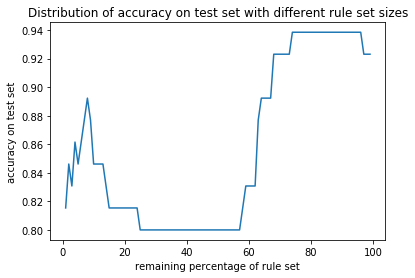

In [65]:
ax = sns.lineplot(percentage, acc)
ax.set(xlabel='remaining percentage of rule set', ylabel='accuracy on test set')
plt.title("Distribution of accuracy on test set with different rule set sizes") 
plt.savefig("plots/rule_score_pers/dist_acc_test_set.svg")

Text(0.5,1,'Distribution of accuracy on test set with different rule set sizes')

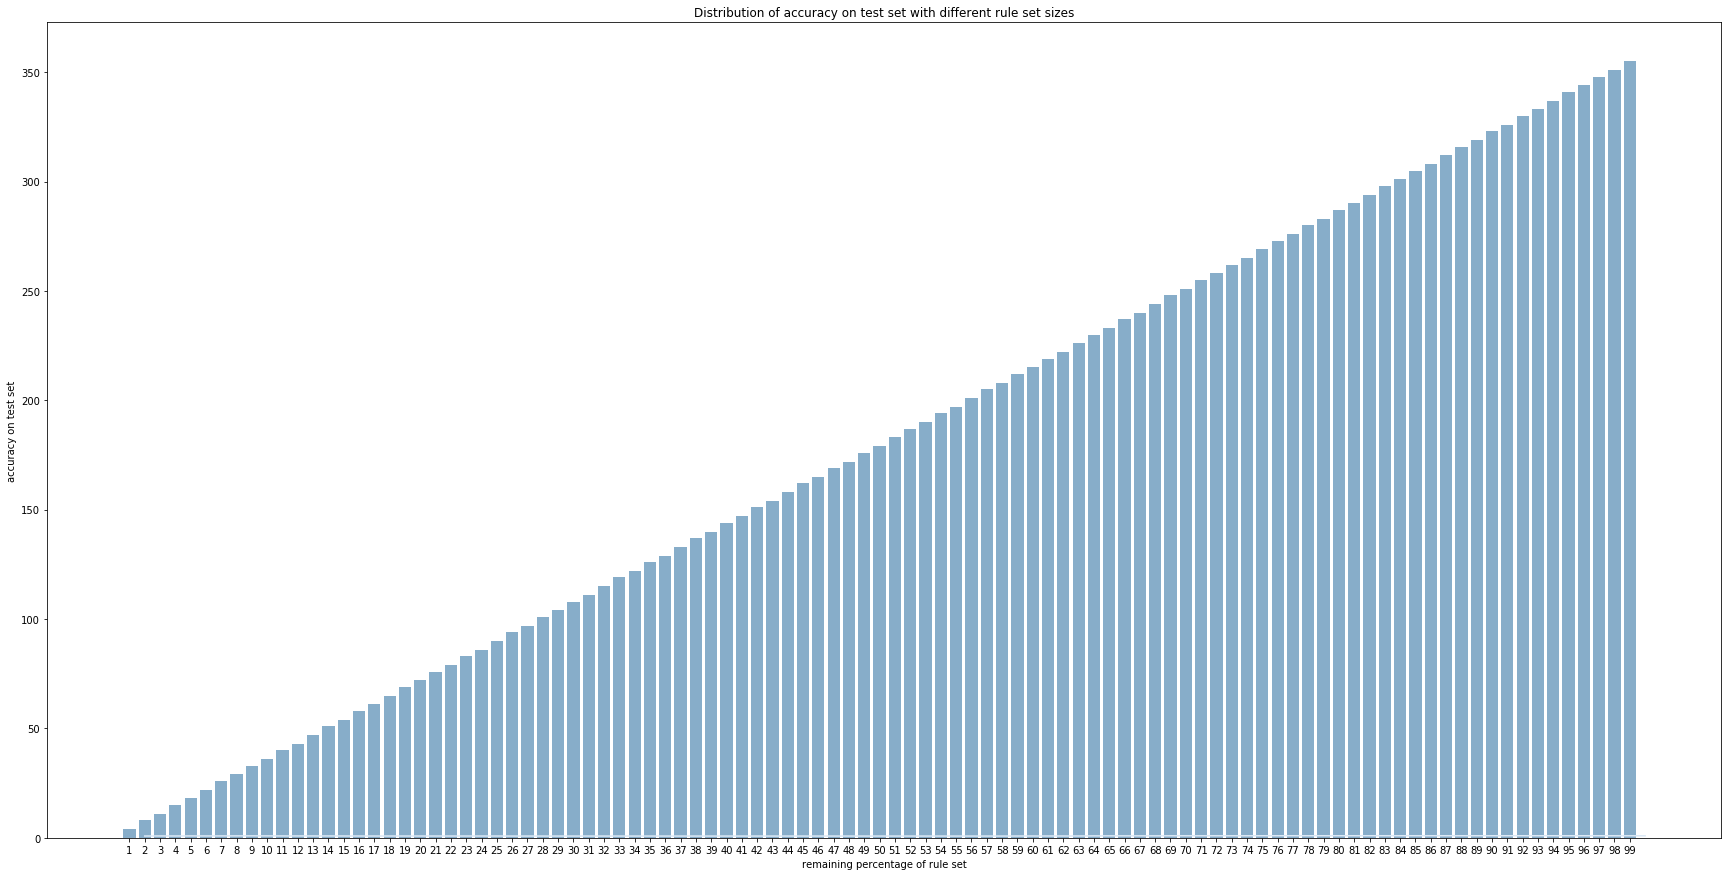

In [87]:
   
plt.figure(figsize=(30,15))

ax = sns.barplot(percentage, number_rules, color="#7caed4")

ax.set(xlabel='remaining percentage of rule set', ylabel='accuracy on test set')
plt.title("Distribution of accuracy on test set with different rule set sizes") 


<Figure size 432x288 with 0 Axes>

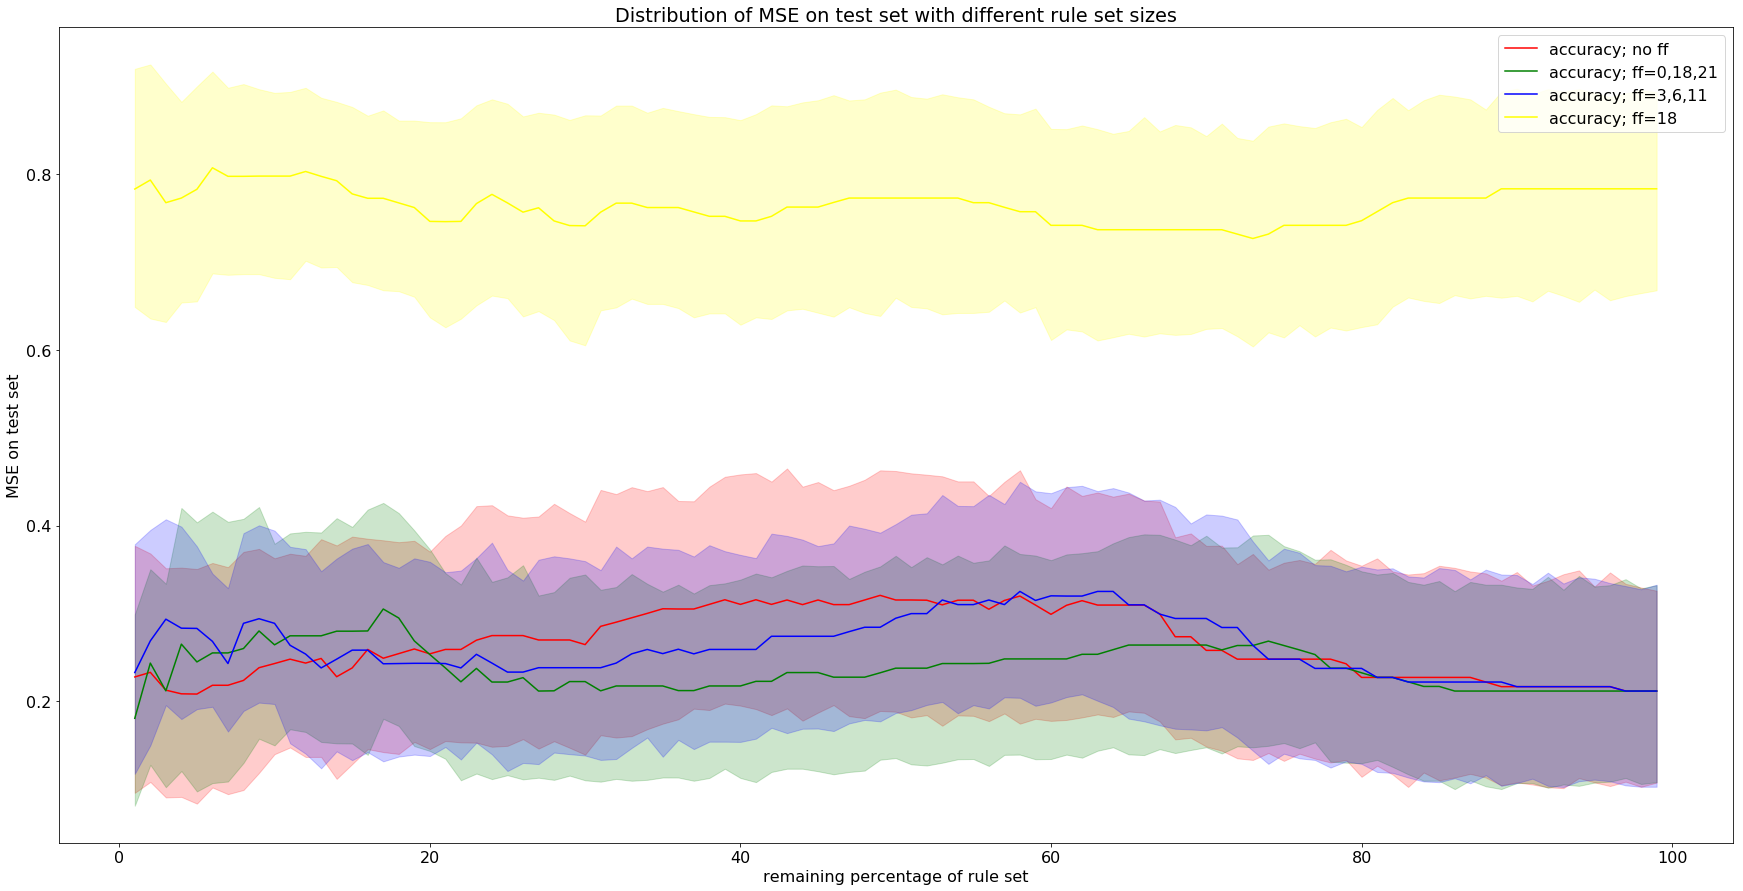

In [35]:
fig = plt.figure()
plt.figure(figsize=(30,15))

#ax1 = sns.barplot(percentage, number_rules, color="#bad1e3", label="number of rules")
#ax2 = ax1.twinx()
ax2 = sns.lineplot(x='percentage', y='mse', data=test_df_no_ff_plus_mse, color='r', label='accuracy; no ff')
#ax3 = sns.lineplot(x='percentage', y='accuracy', data=test_df_123, color='g', label='accuracy; ff=1,2,3')
ax4 = sns.lineplot(x='percentage', y='mse', data=test_df_0_18_21_plus_mse, color='green', label='accuracy; ff=0,18,21')
ax5 = sns.lineplot(x='percentage', y='mse', data=test_df_3_6_11_plus_mse, color='b', label='accuracy; ff=3,6,11')
#ax6 = sns.lineplot(x='percentage', y='accuracy', data=test_df_6_plus_mse, color='orange', label='accuracy; ff=6')
ax7 = sns.lineplot(x='percentage', y='accuracy', data=test_df_18_plus_mse, color='yellow', label='accuracy; ff=18')

#ax2 = sns.lineplot(percentage, acc, color='r', label="accuracy")
ax2.grid(False)
#ax1.set(xlabel='remaining percentage of rule set', ylabel='number of rules in rule set')
ax2.set(xlabel='remaining percentage of rule set', ylabel='MSE on test set')
plt.title("Distribution of MSE on test set with different rule set sizes") 
plt.legend()
#ax1.legend(loc ='upper left')

plt.rcParams.update({'font.size': 16})
#plt.savefig("plots/rule_score_pers/dist_mse_test_set_number_rules_cv_comparison_different_ff_no_bars_ex2.png")
plt.show()

In [17]:
from sklearn.model_selection import KFold
import pandas as pd

In [18]:
def perform_k_fold_cv(nr_folds, favourite_features):
    
    kf = KFold(n_splits=nr_folds)
    data = helpers.create_dataframe("dataWoName.csv")
    
    ground_truth = np.array(groundTruth)
    all_accs = []
    all_mse = []
    dataframe = pd.DataFrame()
    df = pd.DataFrame(columns={'fold', 'accuracy', 'percentage'})
    i = 1
    
    for train_index, test_index in kf.split(X=data, y=ground_truth):
        #print(train_index, test_index)
        x_train = data.iloc[train_index]
        y_train = ground_truth[train_index]
        x_test = data.iloc[test_index]
        y_test = ground_truth[test_index]
        
        #print(len(x_train), len(y_train), len(x_test), len(y_test))

        rf = RandomForest(x_test, y_test, x_train, y_train)
        rules_rf = rf.get_all_rules(forest=rf.rf)
        reducer = Reducer(rules_rf, rf)
        red_ruleset = reducer.reduce_rules()

        print(len(red_ruleset))
        numtoelim = [int((1 - (int(x) / 100)) * len(red_ruleset)) for x in percentage]

        new_ruleset = [reducer.eliminate_weakest_rules_2(favourite_features=favourite_features, k=4, numtoelim=x, ruleset=red_ruleset, xtrain=x_train, ytrain=y_train) for x in numtoelim]
        acc = [rf.get_accuracy_of_ruleset_new(ruleset=x, xtest=x_test, ytest=y_test) for x in new_ruleset]
        mse = [rf.get_mse_of_ruleset_new(ruleset=x, xtest=x_test, ytest=y_test) for x in new_ruleset]
        
        all_accs.append(acc)    
        all_mse.append(mse)
        
        df = df.append(pd.DataFrame({'fold': i, 'accuracy': acc, 'mse': mse, 'percentage': percentage}))
        i += 1

    
    dataframe["folds"] = range(0, nr_folds)
    dataframe["accuracy"] = all_accs
    dataframe["mse"] = all_mse
    
    #ax = sns.lineplot(x="percentage_of_rule_set_kept", y="accuracy", data=dataframe)
    
    return dataframe, df

In [158]:
data = helpers.create_dataframe("dataWoName.csv")
ground_truth = np.array(groundTruth)

kf = KFold(n_splits=5)
train_index, test_index, train_y, a, b = kf.split(X=data, y=ground_truth)

# data.iloc[train_index[0]]
ground_truth[b[0]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [133]:
test_index

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
        182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194]),
 array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
        56, 57, 58, 59, 60, 61, 62, 63, 64, 65

In [23]:
df_test_k_fold_cv_0_18_21_plus_mse, test_df_0_18_21_plus_mse = perform_k_fold_cv(10, [0,18,21])

470


/home/tamara/anaconda3/envs/cdss_python2/lib/python2.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


449
414
457
492
434
479
497
449
353


In [24]:
df_test_k_fold_cv_no_ff_plus_mse, test_df_no_ff_plus_mse = perform_k_fold_cv(10, [])

470
449
414
457
492
434
479
497
449
353


In [28]:
df_test_k_fold_cv_3_6_11_plus_mse, test_df_3_6_11_plus_mse = perform_k_fold_cv(10, [3, 6, 11])

470
449
414
457
492
434
479
497
449
353


In [29]:
df_test_k_fold_cv_18_plus_mse, test_df_18_plus_mse = perform_k_fold_cv(10, [18])

470
449
414
457
492
434
479
497
449
353


In [30]:
df_test_k_fold_cv_6_plus_mse, test_df_6_plus_mse = perform_k_fold_cv(10, [6])

470
449
414
457
492
434
479
497
449
353


In [218]:
df_test_k_fold_cv_no_ff, test_df_no_ff = perform_k_fold_cv(10, [])

470
449
414
457
492
434
479
497
449
353


In [240]:
df_test_k_fold_cv_3_6_11, test_df_3_6_11 = perform_k_fold_cv(10, [3,6,11])

470
449
414
457
492
434
479
497
449
353


In [247]:
df_test_k_fold_cv_6, test_df_6 = perform_k_fold_cv(10, [6])

470
449
414
457
492
434
479
497
449
353


In [255]:
df_test_k_fold_cv_18, test_df_18 = perform_k_fold_cv(10, [18])

470
449
414
457
492
434
479
497
449
353


In [199]:
df_test_k_fold_cv

,folds,accuracy
0,0,"[1.0, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95..."
1,1,"[0.6, 0.65, 0.65, 0.9, 0.9, 0.9, 0.9, 0.9, 0.7..."
2,2,"[0.65, 0.65, 0.8, 0.8, 0.7, 0.6, 0.6, 0.65, 0...."
3,3,"[1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0,..."
4,4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,5,"[0.473684210526, 0.421052631579, 0.42105263157..."
6,6,"[0.947368421053, 0.947368421053, 1.0, 0.894736..."
7,7,"[0.947368421053, 0.894736842105, 0.89473684210..."
8,8,"[0.684210526316, 0.684210526316, 0.68421052631..."
9,9,"[0.421052631579, 0.473684210526, 0.47368421052..."


In [223]:
percentage

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

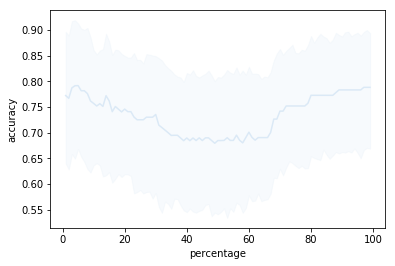

In [200]:
sns.lineplot(x='percentage', y='accuracy', data=test_df)